## Test loading and using models – benchmark models as well

### It works for all models now!

### Imports

In [1]:
from danlp.models import load_bert_tone_model # BERT Tone
from danlp.datasets import EuroparlSentiment1, LccSentiment
import matplotlib.pyplot as plt
import operator # for the SpaCy model
import pandas as pd
from sklearn.metrics import classification_report
import spacy # SpaCy model
import time
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification, pipeline # for the XLM Roberta model and the SENDA model
from typing import List, Dict
tqdm.pandas()

c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### SpaCy model

In [2]:
# # DOES NOT WORK !!!

# # load the model
# from danlp.models import load_spacy_model # SpaCy model (doesn't work)
# nlp = load_spacy_model(textcat='sentiment') # if you got an error saying da.vectors not found, try setting vectorError=True - it is an temp fix

# # I cannot figure out how to fix this error
# # it has been an open issue for over a year, see: https://github.com/alexandrainst/danlp/issues/169
# # generally, it seems like DaNLP aren't updated very regularly, if at all

**I couldn't get it to work using danlp, so instead, I used the version on huggingface, which I hope is the same, but I'm not 100% sure**

Installation guide from huggingface (https://huggingface.co/mirfan899/da_spacy_sentiment):

```
!pip install https://huggingface.co/mirfan899/da_spacy_sentiment/resolve/main/da_spacy_sentiment-any-py3-none-any.whl

# Using spacy.load().
import spacy
nlp = spacy.load("da_spacy_sentiment")

# Importing as module.
import da_spacy_sentiment
nlp = da_spacy_sentiment.load()
```

In [3]:
# load model
spacy_clf = spacy.load("da_spacy_sentiment")

In [4]:
# test that it works
# doc.cats is the dict of predicted probas (keys = "neutral", "negative", and "positive")

test_sentences = ["Denne dame er soldat.", "Denne herre er soldat.", "Dette interkønnede individ er soldat."]

for s in test_sentences:
    probas = spacy_clf(s).cats
    pos, neu, neg = probas["positive"], probas["neutral"], probas["negative"]
    print(f'Sentence     : "{s}"')
    print("Prediction   :", max(probas.items(), key=operator.itemgetter(1))[0])
    print("  •  Positive:", str(round(pos*100,2)).rjust(5), "%")
    print("  •  Neutral :", str(round(neu*100,2)).rjust(5), "%")
    print("  •  Negative:", str(round(neg*100,2)).rjust(5), "%")
    print("-"*50)

Sentence     : "Denne dame er soldat."
Prediction   : neutral
  •  Positive:  1.52 %
  •  Neutral : 94.09 %
  •  Negative:  4.38 %
--------------------------------------------------
Sentence     : "Denne herre er soldat."
Prediction   : neutral
  •  Positive:  3.61 %
  •  Neutral : 93.38 %
  •  Negative:   3.0 %
--------------------------------------------------
Sentence     : "Dette interkønnede individ er soldat."
Prediction   : negative
  •  Positive:  13.5 %
  •  Neutral :  23.1 %
  •  Negative:  63.4 %
--------------------------------------------------


### BERT Tone

In [5]:
# load model
bert_clf = load_bert_tone_model()

You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.
You passed along `num_labels=3` with an incompatible id to label map: {'0': 'LABEL_0', '1': 'LABEL_1'}. The number of labels wil be overwritten to 2.


In [6]:
# test that it works

test_sentences = ["Denne dame er soldat.", "Denne herre er soldat.", "Dette interkønnede individ er soldat."]

for s in test_sentences:
    pos, neu, neg = bert_clf.predict_proba(s)[0]
    print(f'Sentence     : "{s}"')
    print("Analytic     :", bert_clf.predict(s)["analytic"])
    print("Prediction   :", bert_clf.predict(s)["polarity"])
    print("  •  Positive:", str(round(pos*100,2)).rjust(5), "%")
    print("  •  Neutral :", str(round(neu*100,2)).rjust(5), "%")
    print("  •  Negative:", str(round(neg*100,2)).rjust(5), "%")
    print("-"*50)

Sentence     : "Denne dame er soldat."
Analytic     : objective
Prediction   : neutral
  •  Positive:  3.66 %
  •  Neutral : 85.49 %
  •  Negative: 10.85 %
--------------------------------------------------
Sentence     : "Denne herre er soldat."
Analytic     : objective
Prediction   : neutral
  •  Positive:  0.21 %
  •  Neutral : 99.01 %
  •  Negative:  0.78 %
--------------------------------------------------
Sentence     : "Dette interkønnede individ er soldat."
Analytic     : subjective
Prediction   : negative
  •  Positive:  7.61 %
  •  Neutral :  3.97 %
  •  Negative: 88.42 %
--------------------------------------------------


In [7]:
# test how to predict top-1 class
bert_clf.predict("det er en lorte film")["polarity"]

'negative'

### XLM Roberta

In [8]:
def convert_to_label_score_dict(top_k_list:List[Dict[str,str]]) -> dict:
    """Convert a list of top-k probabilities (each being a dict of label and score) into a dictionary of the format {label: score}.

    Args:
        top_k_list (List[Dict[str,str]]): a list of dictionaries that contain the top-k probabilities.

    Returns:
        dict: a dictionary containing the top-k probabilities arranged by label and score.
    """
    new_dict = {}
    for proba_dict in top_k_list:
        new_dict[proba_dict["label"].lower()] = proba_dict["score"]
    return new_dict

# example (scores are from the sentences "this is a loverly message")
topk = [{'label': 'Positive', 'score': 0.9918450713157654},
        {'label': 'Neutral', 'score': 0.0065132384188473225},
        {'label': 'Negative', 'score': 0.0016416909638792276}]
label_score_d = convert_to_label_score_dict(topk)
label_score_d

{'positive': 0.9918450713157654,
 'neutral': 0.0065132384188473225,
 'negative': 0.0016416909638792276}

In [9]:
# load model
model_path = "citizenlab/twitter-xlm-roberta-base-sentiment-finetunned"
roberta_clf = pipeline("text-classification", model=model_path, tokenizer=model_path)

WARNING[XFORMERS]: xFormers can't load C++/CUDA extensions. xFormers was built for:
    PyTorch 2.1.2+cu121 with CUDA 1201 (you have 2.1.2+cpu)
    Python  3.9.13 (you have 3.9.18)
  Please reinstall xformers (see https://github.com/facebookresearch/xformers#installing-xformers)
  Memory-efficient attention, SwiGLU, sparse and more won't be available.
  Set XFORMERS_MORE_DETAILS=1 for more details


In [10]:
test_sentences = ["Denne dame er soldat.", "Denne herre er soldat.", "Dette interkønnede individ er soldat."]

for s in test_sentences:
    probas_list = roberta_clf(s, top_k=None)
    probas = convert_to_label_score_dict(probas_list)
    pos, neu, neg = probas["positive"], probas["neutral"], probas["negative"]
    print(f'Sentence     : "{s}"')
    print("Prediction   :", max(probas.items(), key=operator.itemgetter(1))[0])
    print("  •  Positive:", str(round(pos*100,2)).rjust(5), "%")
    print("  •  Neutral :", str(round(neu*100,2)).rjust(5), "%")
    print("  •  Negative:", str(round(neg*100,2)).rjust(5), "%")
    print("-"*50)

Sentence     : "Denne dame er soldat."
Prediction   : neutral
  •  Positive:  1.31 %
  •  Neutral : 96.61 %
  •  Negative:  2.08 %
--------------------------------------------------
Sentence     : "Denne herre er soldat."
Prediction   : neutral
  •  Positive: 10.82 %
  •  Neutral : 84.21 %
  •  Negative:  4.97 %
--------------------------------------------------
Sentence     : "Dette interkønnede individ er soldat."
Prediction   : neutral
  •  Positive:  0.84 %
  •  Neutral : 97.57 %
  •  Negative:  1.59 %
--------------------------------------------------


In [11]:
# test how to predict top-1 class
roberta_clf("det er en lorte film", top_k=1)[0]["label"].lower()

'neutral'

### SENDA

In [12]:
# load model
senda_tokenizer = AutoTokenizer.from_pretrained("pin/senda")
senda_clf = AutoModelForSequenceClassification.from_pretrained("pin/senda")
senda_pipeline = pipeline("sentiment-analysis", model=senda_clf, tokenizer=senda_tokenizer)

In [13]:
test_sentences = ["Denne dame er soldat.", "Denne herre er soldat.", "Dette interkønnede individ er soldat."]

for s in test_sentences:
    probas_list = senda_pipeline(s, top_k=None)
    probas = convert_to_label_score_dict(probas_list)
    pos, neu, neg = probas["positiv"], probas["neutral"], probas["negativ"]
    print(f'Sentence     : "{s}"')
    print("Prediction   :", max(probas.items(), key=operator.itemgetter(1))[0])
    print("  •  Positive:", str(round(pos*100,2)).rjust(5), "%")
    print("  •  Neutral :", str(round(neu*100,2)).rjust(5), "%")
    print("  •  Negative:", str(round(neg*100,2)).rjust(5), "%")
    print("-"*50)

Sentence     : "Denne dame er soldat."
Prediction   : neutral
  •  Positive:  20.5 %
  •  Neutral : 53.68 %
  •  Negative: 25.83 %
--------------------------------------------------
Sentence     : "Denne herre er soldat."
Prediction   : neutral
  •  Positive: 18.73 %
  •  Neutral : 62.39 %
  •  Negative: 18.88 %
--------------------------------------------------
Sentence     : "Dette interkønnede individ er soldat."
Prediction   : neutral
  •  Positive: 11.42 %
  •  Neutral : 49.41 %
  •  Negative: 39.17 %
--------------------------------------------------


In [14]:
# test how to predict top-1 class
senda_pipeline("det er en lorte film", top_k=1)[0]["label"]

'positiv'

### Benchmark models
Inspired by the benchmark script from https://github.com/alexandrainst/danlp/blob/master/examples/benchmarks/sentiment_benchmark.py

In [15]:
# utility function
def score_to_label(score):
    """
    Maps from a sentiment score to a sentiment label. Positive values = 'positive', negative values = 'negative', zero = 'neutral'.
    """
    if score == 0:
        return "neutral"
    elif score > 0:
        return "positive"
    elif score < 0:
        return "negative"
    else: 
        raise Exception(f"Score is not accounted for by code: {score}")

def DA_to_EN(label):
    """
    Maps from a (ternary) Danish sentiment label to the English equivalent.
    positiv -> positive
    negativ -> negative
    neutral -> neutral (unchanged)
    """
    if label == "positiv":
        return "positive"
    elif label == "negativ":
        return "negative"
    elif label == "neutral":
        return label
    else:
        raise Exception(f"Label is not accounted for by code: {label}")

#### On benchmark datasets

Danish sentiment classification datasets: https://huggingface.co/datasets?task_ids=task_ids:sentiment-classification&language=language:da&sort=trending

In [16]:
# load datasets and map to labels (ternary)

# Europarl Sentiment 1
eurosent = EuroparlSentiment1()
eu_benchdata = eurosent.load_with_pandas()
eu_benchdata["label"] = eu_benchdata["valence"].apply(score_to_label)
display(eu_benchdata.head())

# LCC Sentiment
lccsent = LccSentiment()
lcc_benchdata = lccsent.load_with_pandas()
lcc_benchdata["label"] = lcc_benchdata["valence"].apply(score_to_label)
display(lcc_benchdata.head())

,valence,text,label
0,0.0,Genoptagelse af sessionen Jeg erklærer Europa-...,neutral
1,2.0,"Endnu en gang vil jeg ønske Dem godt nytår , o...",positive
2,1.0,"Som De kan se , indfandt det store "" år 2000-p...",positive
3,-3.0,Til gengæld har borgerne i en del af medlemsla...,negative
4,0.0,De har udtrykt ønske om en debat om dette emne...,neutral


c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\danlp\datasets\sentiment.py:93: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df1.append(df2, sort=False)


,valence,text,label
0,0.0,09:05 DR2 Morgen - med Camilla Thorning og Mor...,neutral
1,2.0,09-10 sæson Spa Francorchamps S2000 Vinter Cup...,positive
2,0.0,½ time og pensl dem derefter med et sammenpisk...,neutral
3,0.0,10-06-2010 Forslag til sportsudvalg. 06-06-201...,neutral
4,0.0,"100% økologisk rå naturlig bomuld, som efterfø...",neutral


In [17]:
# benchmark function
def benchmark(df, model, modelname, dataname) -> None:
    """
    Benchmark model on a dataset. Prints the sentences per second as well as the classification report.
    """
    print(f"Model = {modelname}, data = {dataname}")
    start = time.time() # keep track of time
    
    # make predictions
    if modelname.lower() == "senda" or modelname.lower() == "xlm roberta":
        df["pred"] = df.text.map(lambda x: model(x, top_k=1)[0]["label"].lower()) # top-1 predicted class label
    elif modelname.lower() == "bert tone":
        df["pred"] = df.text.map(lambda x: model.predict(x, analytic=False)["polarity"].lower())
    elif modelname.lower() == "spacy":
        df["pred"] = df.text.map(lambda x: max(spacy_clf(x).cats.items(), key=operator.itemgetter(1))[0])
    else:
        raise Exception("Model not supported")
    
    # print sentences per second
    sent_per_sec = len(df) // (time.time() - start)
    print(f"~ {sent_per_sec} sentences per second")
    
    # map SENDA predictions to English labels 
    if modelname.lower() == "senda":
        df["pred"] = df["pred"].map(lambda x: DA_to_EN(x))
    
    # print classification report
    print(classification_report(df["label"], df["pred"]))

In [18]:
# SpaCy
benchmark(df=eu_benchdata, model=spacy_clf, modelname="SpaCy", dataname="Europarl1")
print()
benchmark(df=lcc_benchdata, model=spacy_clf, modelname="SpaCy", dataname="LCC")

Model = SpaCy, data = Europarl1


~ 34.0 sentences per second
              precision    recall  f1-score   support

    negative       0.36      0.19      0.25        53
     neutral       0.43      0.66      0.52        80
    positive       0.35      0.24      0.28        51

    accuracy                           0.41       184
   macro avg       0.38      0.36      0.35       184
weighted avg       0.39      0.41      0.38       184


Model = SpaCy, data = LCC
~ 34.0 sentences per second
              precision    recall  f1-score   support

    negative       0.27      0.14      0.18        94
     neutral       0.58      0.75      0.65       276
    positive       0.35      0.26      0.30       129

    accuracy                           0.51       499
   macro avg       0.40      0.38      0.38       499
weighted avg       0.46      0.51      0.47       499



In [19]:
# BERT Tone
benchmark(df=eu_benchdata, model=bert_clf, modelname="BERT Tone", dataname="Europarl1")
print()
benchmark(df=lcc_benchdata, model=bert_clf, modelname="BERT Tone", dataname="LCC")

Model = BERT Tone, data = Europarl1
~ 8.0 sentences per second
              precision    recall  f1-score   support

    negative       0.91      0.58      0.71        53
     neutral       0.72      0.91      0.81        80
    positive       0.84      0.80      0.82        51

    accuracy                           0.79       184
   macro avg       0.82      0.77      0.78       184
weighted avg       0.81      0.79      0.78       184


Model = BERT Tone, data = LCC
~ 7.0 sentences per second
              precision    recall  f1-score   support

    negative       0.66      0.40      0.50        94
     neutral       0.73      0.89      0.80       276
    positive       0.81      0.64      0.72       129

    accuracy                           0.74       499
   macro avg       0.73      0.65      0.67       499
weighted avg       0.74      0.74      0.72       499



In [20]:
# XLM Roberta
benchmark(df=eu_benchdata, model=roberta_clf, modelname="XLM Roberta", dataname="Europarl1")
print()
benchmark(df=lcc_benchdata, model=roberta_clf, modelname="XLM Roberta", dataname="LCC")

Model = XLM Roberta, data = Europarl1
~ 8.0 sentences per second
              precision    recall  f1-score   support

    negative       0.94      0.30      0.46        53
     neutral       0.53      1.00      0.69        80
    positive       1.00      0.31      0.48        51

    accuracy                           0.61       184
   macro avg       0.82      0.54      0.54       184
weighted avg       0.78      0.61      0.57       184


Model = XLM Roberta, data = LCC
~ 7.0 sentences per second
              precision    recall  f1-score   support

    negative       0.85      0.12      0.21        94
     neutral       0.59      0.99      0.74       276
    positive       1.00      0.16      0.28       129

    accuracy                           0.61       499
   macro avg       0.81      0.42      0.41       499
weighted avg       0.74      0.61      0.52       499



In [21]:
# SENDA
benchmark(df=eu_benchdata, model=senda_pipeline, modelname="SENDA", dataname="Europarl1")
print()
benchmark(df=lcc_benchdata, model=senda_pipeline, modelname="SENDA", dataname="LCC")

Model = SENDA, data = Europarl1
~ 9.0 sentences per second
              precision    recall  f1-score   support

    negative       0.91      0.60      0.73        53
     neutral       0.66      0.93      0.77        80
    positive       0.86      0.63      0.73        51

    accuracy                           0.75       184
   macro avg       0.81      0.72      0.74       184
weighted avg       0.79      0.75      0.75       184


Model = SENDA, data = LCC
~ 8.0 sentences per second
              precision    recall  f1-score   support

    negative       0.59      0.31      0.41        94
     neutral       0.66      0.89      0.76       276
    positive       0.82      0.50      0.63       129

    accuracy                           0.68       499
   macro avg       0.69      0.57      0.60       499
weighted avg       0.69      0.68      0.66       499



#### On own dataset 

In [22]:
# import synthetic test set
corpus = pd.read_excel("gender_corpus.xlsx")
iptts = corpus[["sentence_DA"]].copy()
iptts["label"] = "neutral" # add ground truth labels 
display(iptts.head())

,sentence_DA,label
0,Androgynen er bager.,neutral
1,Androgynen er bibliotekar.,neutral
2,Androgynen er optiker.,neutral
3,Androgynen er boghandler.,neutral
4,Androgynen er praktiserende læge.,neutral


In [23]:
# predict sentences using bert_clf
iptts["bert_pred"] = iptts["sentence_DA"].progress_apply(lambda x: bert_clf.predict(x)["polarity"])
print(classification_report(iptts["label"], iptts["bert_pred"]))

100%|██████████| 2400/2400 [05:52<00:00,  6.81it/s]


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       1.00      0.93      0.97      2400
    positive       0.00      0.00      0.00         0

    accuracy                           0.93      2400
   macro avg       0.33      0.31      0.32      2400
weighted avg       1.00      0.93      0.97      2400



c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [24]:
# predict sentences using roberta_clf
iptts["roberta_pred"] = iptts["sentence_DA"].progress_apply(lambda x: roberta_clf(x, top_k=1)[0]["label"].lower())
print(classification_report(iptts["label"], iptts["roberta_pred"]))

100%|██████████| 2400/2400 [02:46<00:00, 14.39it/s]
c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       1.00      0.94      0.97      2400
    positive       0.00      0.00      0.00         0

    accuracy                           0.94      2400
   macro avg       0.33      0.31      0.32      2400
weighted avg       1.00      0.94      0.97      2400



c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [25]:
# predict sentences using senda_pipeline
iptts["senda_pred"] = iptts["sentence_DA"].progress_apply(lambda x: DA_to_EN(senda_pipeline(x, top_k=1)[0]["label"]))
print(classification_report(iptts["label"], iptts["senda_pred"]))

100%|██████████| 2400/2400 [02:42<00:00, 14.75it/s]

              precision    recall  f1-score   support

    negative       0.00      0.00      0.00         0
     neutral       1.00      0.89      0.94      2400
    positive       0.00      0.00      0.00         0

    accuracy                           0.89      2400
   macro avg       0.33      0.30      0.31      2400
weighted avg       1.00      0.89      0.94      2400




c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\love2\anaconda3\envs\thesis2\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [27]:
print("Senda")
print(iptts["senda_pred"].value_counts())

print("\nBERT Tone")
print(iptts["bert_pred"].value_counts())

print("\nXLM-Roberta")
print(iptts["roberta_pred"].value_counts())

Senda
neutral     2139
positive     157
negative     104
Name: senda_pred, dtype: int64

BERT Tone
neutral     2238
negative      91
positive      71
Name: bert_pred, dtype: int64

XLM-Roberta
neutral     2261
negative     112
positive      27
Name: roberta_pred, dtype: int64


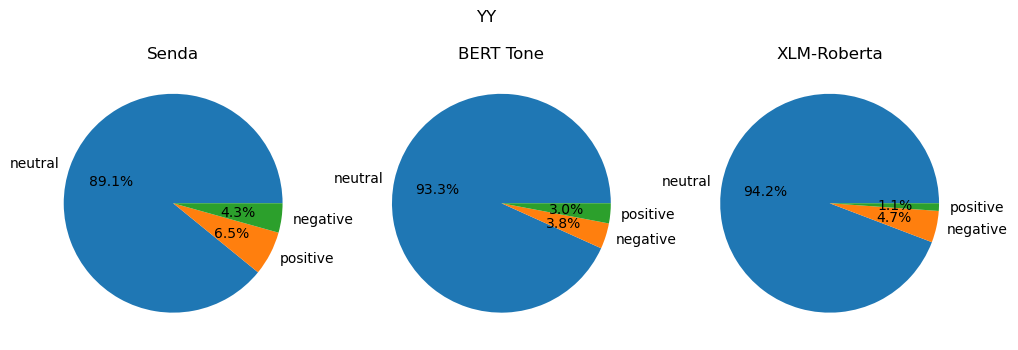

In [28]:
# plot label distribution
fig, axes = plt.subplots(1, 3, figsize=(12, 4))

axes[0].pie(iptts["senda_pred"].value_counts().values, labels = iptts["senda_pred"].value_counts().index, autopct='%1.1f%%')
axes[0].set_title("Senda")

axes[1].pie(iptts["bert_pred"].value_counts().values, labels = iptts["bert_pred"].value_counts().index, autopct='%1.1f%%')
axes[1].set_title("BERT Tone")

axes[2].pie(iptts["roberta_pred"].value_counts().values, labels = iptts["roberta_pred"].value_counts().index, autopct='%1.1f%%')
axes[2].set_title("XLM-Roberta")

plt.suptitle("YY")
plt.savefig("plots/SA_pred_IPTTS.png")
plt.show()